---
author:
  - Lena Pöpping
  - Remco de Boer
date: 2025-04-14
format:
  html:
    code-links:
      - href: lite/lab/index.html?path=finding-poles-2channels.ipynb
        icon: play
        text: Run code
---

# Poles in a 2x2 $K$&nbsp;matrix

In [36]:
# | echo: false
# | output: false
%config InlineBackend.figure_format = 'svg'
%pip install ampform~=0.15.0

/home/lena/work/RUB-EP1/kmatrix-day-2025/.pixi/envs/default/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# | code-fold: true
# | code-summary: Import Python libraries
from collections.abc import Callable
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from ampform.io import aslatex
from ampform.kinematics.phasespace import Kallen
from ampform.sympy import unevaluated
from iminuit import Minuit
from IPython.display import Math
from matplotlib import colors

:::{.callout-tip}
See the [Finding poles](./finding-poles.ipynb) notebook for more explanation on the phase space factors and the procedure for finding a pole and computing a residue in the unphysical sheet.
:::

In [38]:
# | code-fold: true
# | code-summary: Definition of phase space factors
@unevaluated(real=False)
class PhaseSpaceFactor(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\rho_{{{m1},{m2}}}\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return sp.sqrt(s - (m1 + m2) ** 2) * sp.sqrt(s - (m1 - m2) ** 2) / s


@unevaluated(real=False)
class PhaseSpaceFactorCM(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\rho_{{{m1},{m2}}}^\mathrm{{CM}}\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return -16 * sp.pi * sp.I * ChewMandelstam(s, m1, m2)


@unevaluated(real=False)
class ChewMandelstam(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\Sigma\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        q = BreakupMomentum(s, m1, m2)
        return (
            1
            / (16 * sp.pi**2)
            * (
                (2 * q / sp.sqrt(s))
                * sp.log((m1**2 + m2**2 - s + 2 * sp.sqrt(s) * q) / (2 * m1 * m2))
                - (m1**2 - m2**2) * (1 / s - 1 / (m1 + m2) ** 2) * sp.log(m1 / m2)
            )
        )


@unevaluated(real=False)
class BreakupMomentum(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"q\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return sp.sqrt(Kallen(s, m1**2, m2**2)) / (2 * sp.sqrt(s))


class DiagonalMatrix(sp.DiagonalMatrix):
    def _latex(self, printer, *args):  # noqa: ARG002
        return printer._print(self.args[0])


args = sp.symbols("s m_a m_b")
exprs = [
    PhaseSpaceFactor(*args),
    PhaseSpaceFactorCM(*args),
    ChewMandelstam(*args),
    BreakupMomentum(*args),
]
Math(aslatex({expr: expr.doit(deep=False) for expr in exprs}))

<IPython.core.display.Math object>

## Formulate $T$-matrix

In [39]:
n = 2
K = sp.MatrixSymbol("K", n, n)
CM = DiagonalMatrix(sp.MatrixSymbol(R"\rho^\mathrm{CM}", n, n))
rho = DiagonalMatrix(sp.MatrixSymbol("rho", n, n))
I = sp.Identity(n)

In [40]:
T1 = (I - sp.I * K * CM).inv() * K
T1

(I - I*K*DiagonalMatrix(\rho^\mathrm{CM}))**(-1)*K

In [41]:
s, g1, g2, m1 = sp.symbols("s g1 g2 m1")
ma, mb, mc, md = sp.symbols("m_a m_b m_c m_d")

In [42]:
substitutions = {
    K[0, 0]: g1**2 / (m1**2 - s),
    K[1, 1]: g2**2 / (m1**2 - s),
    K[0, 1]: g2 * g1 / (m1**2 - s),
    K[1, 0]: g2 * g1 / (m1**2 - s),
    CM[0, 0]: PhaseSpaceFactorCM(s, ma, mb),
    CM[1, 1]: PhaseSpaceFactorCM(s, mc, md),
}
Math(aslatex(substitutions))

<IPython.core.display.Math object>

Indeed, the expression for sheet I looks like a Flatté function (multichannel Breit–Wigner)!

In [43]:
T1.as_explicit().subs(substitutions).simplify(doit=False)[0, 0]

-g1**2/(I*g1**2*PhaseSpaceFactorCM(s, m_a, m_b) + I*g2**2*PhaseSpaceFactorCM(s, m_c, m_d) - m1**2 + s)

In [44]:
T1_expr = T1.as_explicit().subs(substitutions)
T1_expr_00 = T1_expr[0, 0]
T1_expr_11 = T1_expr[1, 1]

The second and third sheet are again calculated through the discontinuity of the $T$ matrix across the branch cut:

$$
\begin{align}
\operatorname{Disc}_{\mathrm{I,II}} T^{-1}
&= 2 i\left[\begin{array}{rr}\rho_1 & 0  \\ 0 & 0 \end{array}\right] \\
\operatorname{Disc}_{\mathrm{I,III}} T^{-1}
&= 2 i\left[\begin{array}{rr}\rho_1 & 0  \\ 0 & \rho_2 \end{array}\right]
\end{align}
$$

Depending on the centre-of-mass energy, different Riemann sheets connect smoothly to the physical one. In our case the resonance mass will be above the threshold for the first **and** the second channel. Therefore the resonance is expected to be located on the third sheet.

In [45]:
Ti = (T1.inv() - 2 * sp.I * rho).inv()
Ti

(-(2*I)*DiagonalMatrix(rho) + K**(-1)*(I - I*K*DiagonalMatrix(\rho^\mathrm{CM})))**(-1)

In [46]:
rho_subs_II = {
    **substitutions,
    rho[0, 0]: PhaseSpaceFactor(s, ma, mb),
    rho[1, 1]: 0,
}
rho_subs_III = {
    **substitutions,
    rho[0, 0]: PhaseSpaceFactor(s, ma, mb),
    rho[1, 1]: PhaseSpaceFactor(s, mc, md),
}

In [47]:
T2_expr = Ti.as_explicit().subs(rho_subs_II)
T3_expr = Ti.as_explicit().subs(rho_subs_III)

In [48]:
parameters = {
    m1: 0.8,
    g1: 0.4,
    g2: 0.3,
    ma: 0.1,
    mb: 0.15,
    mc: 0.25,
    md: 0.4,
}

In [49]:
# | code-fold: true
# | code-summary: Create numerical functions for $T$ matrices
def lambdify_matrix_expression(matrix_expr: sp.Matrix) -> np.ndarray:
    return np.array([
        [sp.lambdify(s, matrix_expr[i, j].doit().subs(parameters)) for i in range(n)]
        for j in range(n)
    ])


T1_func = lambdify_matrix_expression(T1_expr)
T2_func = lambdify_matrix_expression(T2_expr)
T3_func = lambdify_matrix_expression(T3_expr)

In [50]:
thr1 = (parameters[ma] + parameters[mb]) ** 2
thr2 = (parameters[mc] + parameters[md]) ** 2

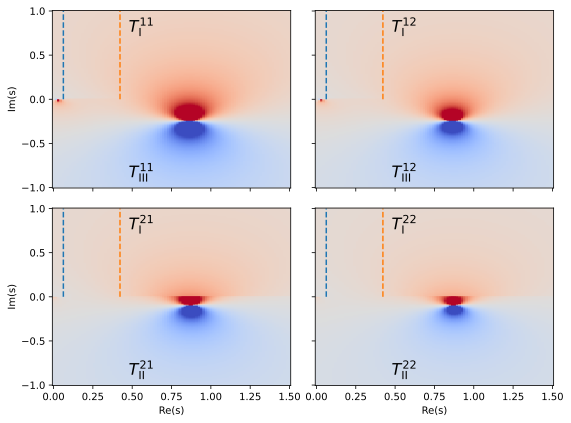

In [51]:
# | code-fold: true
Y_max = 1
X, Y = np.meshgrid(
    np.linspace(0, 1.5, num=100),
    np.linspace(1e-8, Y_max, num=100),
)
S = X + 1j * Y

style = dict(cmap=plt.cm.coolwarm, rasterized=True, vmin=-1, vmax=1)
text_kwargs = dict(c="black", fontsize=16)

fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=2, sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.pcolormesh(X, Y, T1_func[0, 0](S).imag, **style)
ax1.pcolormesh(X, -Y, T3_func[0, 0](S.conj()).imag, **style)
ax1.text(0.32, 0.88, R"$T_\mathrm{I}^{11}$", transform=ax1.transAxes, **text_kwargs)  # noqa: RUF027
ax1.text(0.32, 0.06, R"$T_\mathrm{III}^{11}$", transform=ax1.transAxes, **text_kwargs)

ax2.pcolormesh(X, +Y, T1_func[0, 1](S).imag, **style)
ax2.pcolormesh(X, -Y, T3_func[0, 1](S.conj()).imag, **style)
ax2.text(0.32, 0.88, R"$T_\mathrm{I}^{12}$", transform=ax2.transAxes, **text_kwargs)  # noqa: RUF027
ax2.text(0.32, 0.06, R"$T_\mathrm{III}^{12}$", transform=ax2.transAxes, **text_kwargs)

ax3.pcolormesh(X, +Y, T1_func[1, 0](S).imag, **style)
ax3.pcolormesh(X, -Y, T2_func[1, 0](S.conj()).imag, **style)
ax3.text(0.32, 0.88, R"$T_\mathrm{I}^{21}$", transform=ax3.transAxes, **text_kwargs)  # noqa: RUF027
ax3.text(0.32, 0.06, R"$T_\mathrm{II}^{21}$", transform=ax3.transAxes, **text_kwargs)


ax4.pcolormesh(X, +Y, T1_func[1, 1](S).imag, **style)
ax4.pcolormesh(X, -Y, T2_func[1, 1](S.conj()).imag, **style)
ax4.text(0.32, 0.88, R"$T_\mathrm{I}^{22}$", transform=ax4.transAxes, **text_kwargs)  # noqa: RUF027
ax4.text(0.32, 0.06, R"$T_\mathrm{II}^{22}$", transform=ax4.transAxes, **text_kwargs)

for ax in axes.flatten():
    ax.vlines(thr1, 0, Y_max, color="C0", ls="--")
    ax.vlines(thr2, 0, Y_max, color="C1", ls="--")
for ax in axes[1]:
    ax.set_xlabel("Re(s)")
for ax in axes[:, 0]:
    ax.set_ylabel("Im(s)")
fig.tight_layout()
plt.show()

## Find pole positions

In [52]:
def get_denominator_functions(matrix_expr: sp.Matrix, parameters: dict) -> np.ndarray:
    return np.array([
        [lambdify_denominator(matrix_expr[i, j], parameters) for i in range(n)]
        for j in range(n)
    ])


def lambdify_denominator(expr: sp.Expr, parameters: dict) -> Callable:
    _, denominator = sp.fraction(expr)
    return sp.lambdify(s, denominator.doit().subs(parameters))


T2_denom_func = get_denominator_functions(T2_expr, parameters)
T3_denom_func = get_denominator_functions(T3_expr, parameters)

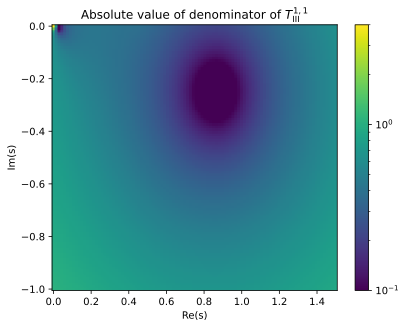

In [53]:
# | code-fold: true
Z = np.abs(T3_denom_func[0, 0](S.conj()))
plt.title(R"Absolute value of denominator of $T_\mathrm{III}^{1, 1}$")
plt.pcolormesh(X, -Y, Z, rasterized=True, norm=colors.LogNorm(vmin=0.1, vmax=4))
plt.colorbar()
plt.xlabel("Re(s)")
plt.ylabel("Im(s)")
plt.show()

In [54]:
# | code-fold: true
def fit_pole(func, s_guess: complex) -> complex:
    def cost_function(s_real: float, s_imag: float) -> float:
        s = s_real + s_imag * 1j
        return np.abs(func(s)) ** 2

    minuit2 = Minuit(cost_function, s_guess.real, s_guess.imag)
    minuit2.tol = 0.001
    fit_result = minuit2.migrad()
    return complex(*fit_result.values)

In [55]:
poles_positions_II = np.array([
    [
        fit_pole(T2_denom_func[0, 0], s_guess=0.8 - 0.3j),
        fit_pole(T2_denom_func[0, 1], s_guess=0.8 - 0.3j),
    ],
    [
        fit_pole(T2_denom_func[1, 0], s_guess=0.8 - 0.3j),
        fit_pole(T2_denom_func[1, 1], s_guess=0.8 - 0.3j),
    ],
])
poles_positions_II.round(3)

array([[0.873-0.102j, 0.873-0.102j],
       [0.873-0.102j, 0.873-0.102j]])

## Compute residues

In [56]:
def compute_residue(f, z0, radius=1e-3, n_points=1_000):
    phi = np.linspace(-np.pi, np.pi, n_points, endpoint=False)
    z = z0 + radius * np.exp(1j * phi)
    return radius / n_points * np.sum(f(z) * np.exp(1j * phi))

In [57]:
residues_II = np.array([
    [
        compute_residue(T2_func[0, 0], z0=poles_positions_II[0, 0]),
        compute_residue(T2_func[0, 1], z0=poles_positions_II[0, 1]),
    ],
    [
        compute_residue(T2_func[1, 0], z0=poles_positions_II[1, 0]),
        compute_residue(T2_func[1, 1], z0=poles_positions_II[1, 1]),
    ],
])
residues_II.round(3)

array([[-0.179-0.008j, -0.134-0.006j],
       [-0.134-0.006j, -0.101-0.005j]])

In [58]:
np.linalg.matrix_rank(residues_II) 

np.int64(1)

In [59]:
np.testing.assert_almost_equal(np.linalg.det(residues_II), 0)

In [60]:
eigenvalues = np.linalg.eigvals(residues_II)
eigenvalues.round(5)

array([-0.27993-0.01324j,  0.     +0.j     ])

In [61]:
residues_II[0, 0] + residues_II[1, 1] 

np.complex128(-0.2799264042985179-0.013242078811281453j)

The residue matrix is defined as:

$$
R_{ij} = \frac{1}{2\pi i}  \oint T^\mathrm{II}_{ij}(s) \, \mathrm{d}s
$$
it gives strength of the coupling between the different channels via, in this case, a single dominating resonance. It has has determinant $0$ and only **one** non-zero eigenvalue. Therefore it is a rank one matrix which means it can be written as the outer product of two vectors:
$$
R= g \cdot g^T
$$
where $g=(g_1,g_2)$ corresponds to the vector consisting of the respective coupling of the resonance to each channel.
The eigenvalues can be found with:
$$
\det(R - \lambda I) = 0
$$

Compute:
$$
\det\begin{pmatrix}
g_1^2 - \lambda & g_1 g_2 \\
g_1 g_2 & g_2^2 - \lambda
\end{pmatrix}

= (g_1^2 - \lambda)(g_2^2 - \lambda) - (g_1 g_2)^2

= g_1^2 g_2^2 - \lambda g_1^2 - \lambda g_2^2 + \lambda^2 - g_1^2 g_2^2
$$

With the determinant beeing zero this leads to:
$$
\lambda^2 - \lambda(g_1^2 + g_2^2) = 0
$$
from this we can find the eigenvalues:  
$$
\lambda_1 = 0, \quad \lambda_2 = g_1^2 + g_2^2
$$

The single non-zero eigenvalue $g_1^2 + g_2^2 $ acts as a over-all scaling factor on coupling vector an can be interpreted as **total strength / width (?)** of the resonance.


